<a href="https://colab.research.google.com/github/mineramc/GTSRB_image_recognition/blob/master/GTSRB_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import os
import cv2
from PIL import Image, ImageOps

from sklearn.svm import SVC

Load Data from Kaggle

> remember to load kaggle.json

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.


In [2]:
! pip install kaggle;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 612M/612M [00:12<00:00, 54.9MB/s]
100% 612M/612M [00:12<00:00, 53.0MB/s]


In [7]:
! mkdir data

In [8]:
! unzip gtsrb-german-traffic-sign.zip -d data > /dev/null 2>&1

Data Setup


1. training and testing images are imported and converted from NumPy array to PIL image.
2.    images are resized to the same height and width and training images are shuffled. Meanwhile, labels for training and testing image data are also retrieved and stored as arrays.
3.   Also, images are normalized by dividing 255 (since image pixel values range from 0 to 256).
4.   Since the RF and SVM algorithms from scikit-learn expect the inputs to be 2D array, the read-in images (with 4 dimensions) are then reshaped to 2D.
5. Fit the random forest and SVM using train data and make predictions with test data. Confusion matrix and classification accuracy are obtained for all three types of input images.








In [9]:
data_dir = '/content/data'
train_path = '/content/data/Train'
test_path = '/content/data/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

num_classes = len(os.listdir(train_path))
num_classes

43

Load Training Data

In [10]:
image_data = []
image_labels = []
grey_data = []
crop_data = []

# Read in training data
for i in range(num_classes):
    path = train_path + '/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            grey_img = ImageOps.grayscale(resize_image)
            image_data.append(np.array(resize_image))
            image_labels.append(i)
            grey_data.append(np.array(grey_img))
        except:
            print("Error in " + img)

# list -> numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
grey_data = np.array(grey_data)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [13]:
# cropping images
train = pd.read_csv(data_dir + '/Train.csv')

data = train[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path']]
imgs = train['Path'].values

crop_data = []
grey_crop_dat = []
# im1 = im.crop((left, top, right, bottom))

for index, row in train.iterrows():
    try:
        image = cv2.imread(data_dir + '/' + row['Path'])
        image_fromarray = Image.fromarray(image, 'RGB')
        cropped_img = image_fromarray.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
        resize_image = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
        greyscale_img = ImageOps.grayscale(resize_image)
        crop_data.append(np.array(resize_image))
        grey_crop_dat.append(np.array(greyscale_img))
    except:
        print("Error in " + img)

crop_data = np.array(crop_data)
grey_crop_dat = np.array(grey_crop_dat)

print(crop_data.shape, grey_crop_dat.shape)

(39209, 30, 30, 3) (39209, 30, 30)


In [14]:
shuffle_indexes = np.arange(image_data.shape[0]) #return numpy array [0,1,2,...,39206,39207,39208]
# image_data.shape = (39209, 30, 30, 3)
np.random.shuffle(shuffle_indexes) # shuffles index

# shuffles the data with shuffled indices
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]
grey_data = grey_data[shuffle_indexes]
crop_data = crop_data[shuffle_indexes] 
grey_crop_dat = grey_crop_dat[shuffle_indexes]

X_train = image_data
y_train = image_labels
grey_X_train = grey_data
crop_X_train = crop_data
crop_grey_X_train = grey_crop_dat

Load Test Data

In [15]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values
crop_coords = test[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

data = []
greyscale_data = []
crop_data = []
crop_grey_dat = []


#read in test data
for index, row in test.iterrows():
    try:
        image = cv2.imread(data_dir + '/' + row['Path'])
        image_fromarray = Image.fromarray(image, 'RGB')
        cropped_img = image_fromarray.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        crop_resize = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
        greyscale_img = ImageOps.grayscale(resize_image)
        crop_grey = ImageOps.grayscale(crop_resize)
        data.append(np.array(resize_image))
        greyscale_data.append(np.array(greyscale_img))
        crop_data.append(np.array(crop_resize))
        crop_grey_dat.append(np.array(crop_grey))
    except:
        print("Error in " + img)

X_test = np.array(data)
y_test = labels
grey_X_test = np.array(greyscale_data)
crop_X_test = np.array(crop_data)
crop_g_X_test = np.array(crop_grey_dat)


In [16]:
# normalize data by dividing by 255 so values are between 0 and 1 making computation more efficient
X_train, X_test= X_train/255, X_test/255
grey_X_train, grey_X_test = grey_X_train/255, grey_X_test/255
crop_X_train, crop_grey_X_train = crop_X_train/255, crop_grey_X_train/255
crop_X_test, crop_g_X_test = crop_X_test/255, crop_g_X_test/255

Reshape 4d array -> 2d for sklearn model

In [17]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples, nx*ny*nrgb))

#so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = X_test.shape
X_test2 =  X_test.reshape((nsamples,nx*ny*nrgb))

# greyscale data
nsamples, nx, ny = grey_X_train.shape
grey_X_train2 = grey_X_train.reshape((nsamples, nx*ny))

nsamples, nx, ny = grey_X_test.shape
grey_X_test2 = grey_X_test.reshape((nsamples, nx*ny))

# crop/crop_grey train data
nsamples, nx, ny , nrgb = crop_X_train.shape
crop_X_train2 = crop_X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny = crop_grey_X_train.shape
crop_grey_X_train2 = crop_grey_X_train.reshape((nsamples, nx*ny))

# crop/crop_grey test data
nsamples, nx, ny, nrgb = crop_X_test.shape
crop_X_test2 = crop_X_test.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny = crop_g_X_test.shape
crop_g_X_test2 = crop_g_X_test.reshape((nsamples, nx*ny))

# new array is nrows = number of images, ncols = number of pixels per image

## Final Datasets for fitting

1. Original
> X_train2, X_test2
2. Greyscale
> grey_X_train2, grey_X_test2
3. Crop
> crop_X_train2, crop_X_test2
4. Cropped and Greyscale
> crop_grey_X_train2, crop_g_X_test2

# Generating SVM

SVM for original images

In [18]:
from sklearn.svm import SVC

In [16]:
#Create a svm Classifier
svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
svm.fit(X_train2, y_train)

#Predict the response for test dataset
y_pred = svm.predict(X_test2)



In [17]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8226444972288203


Text(0.5, 48.25, 'Predicted label')

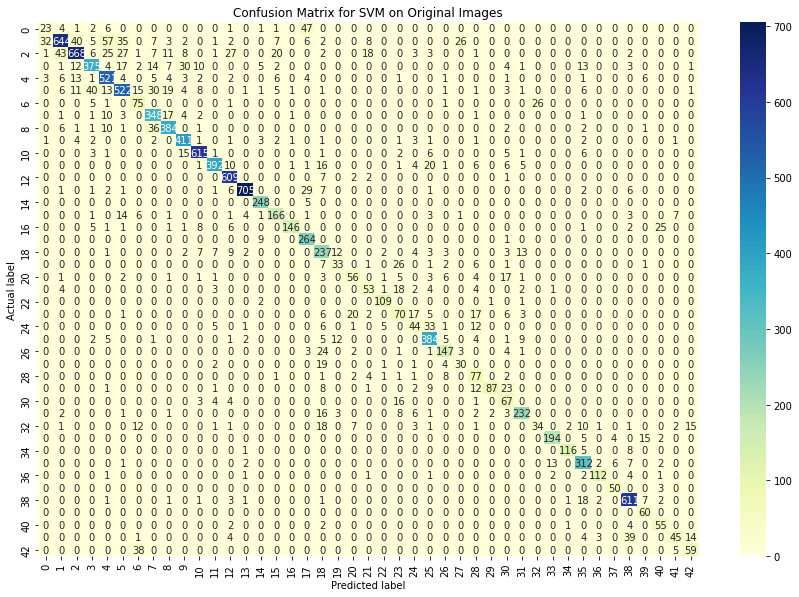

In [18]:
conf_mat_svm = confusion_matrix(y_pred, y_test)

#obtain the confusion matrix heatmap

class_names = [0,1]

plt.figure(figsize=(12,8))
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(conf_mat_svm), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for SVM on Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

SVM for greyscale images

In [19]:
from sklearn.svm import SVC

#Create a svm Classifier
grey_svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
grey_svm.fit(grey_X_train2, y_train)

SVC(gamma='auto', kernel='linear')

In [20]:
#Predict the response for test dataset
grey_y_pred = grey_svm.predict(grey_X_test2)

In [21]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, grey_y_pred))

Accuracy: 0.8261282660332542


Text(0.5, 48.25, 'Predicted label')

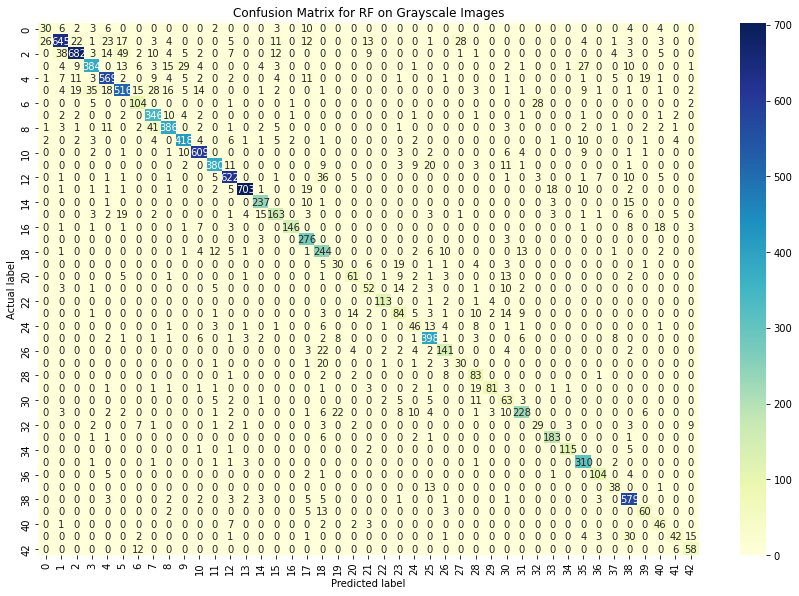

In [22]:
#obtain the confusion matrix heatmap
conf_mat_svm_gray = confusion_matrix(grey_y_pred, y_test)
class_names = [0,1]

plt.figure(figsize=(12,8))
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(conf_mat_svm_gray), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Grayscale Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

SVM for cropped


data: crop_X_train2, crop_X_test2

In [ ]:
#Create a svm Classifier
crop_svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
crop_svm.fit(crop_X_train2, y_train)

Runtime: 6m

In [24]:
#Predict the response for test dataset
crop_y_pred = crop_svm.predict(crop_X_test2)

In [25]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, crop_y_pred))

Accuracy: 0.7307205067300079


Text(0.5, 48.25, 'Predicted label')

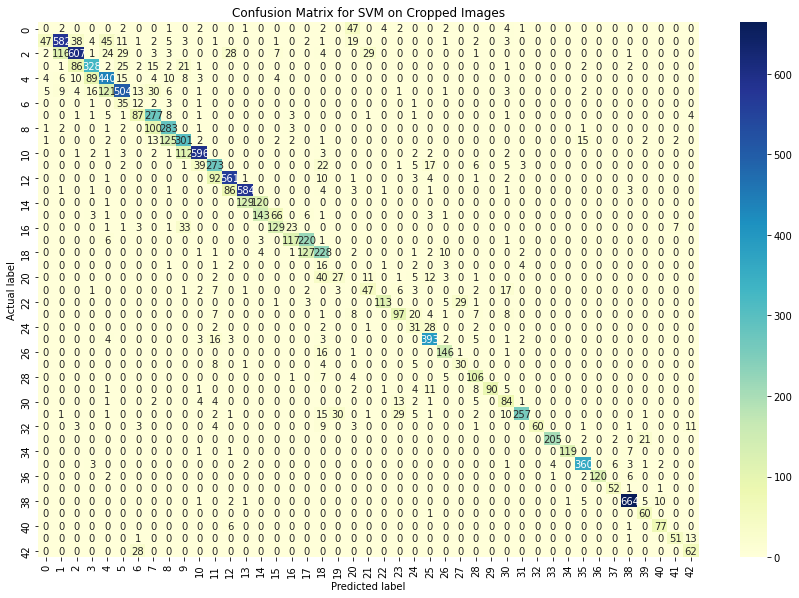

In [26]:
#obtain the confusion matrix heatmap
conf_mat_svm_crop = confusion_matrix(crop_y_pred, y_test)
class_names = [0,1]

plt.figure(figsize=(12,8))
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(conf_mat_svm_crop), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for SVM on Cropped Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

SVM for cropeed and grey

data: crop_grey_X_train2, crop_g_X_test2

In [27]:
#Create a svm Classifier
crop_g_svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
crop_g_svm.fit(crop_grey_X_train2, y_train)

SVC(gamma='auto', kernel='linear')

In [28]:
#Predict the response for test dataset
crop_g_y_pred = crop_g_svm.predict(crop_g_X_test2)

In [29]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, crop_g_y_pred))

Accuracy: 0.739588281868567
